In [1]:
# Import necessary libraries

%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

import cv2
import imutils
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import shutil
import os
from os import listdir
import random
import scipy
from scipy import ndimage, misc

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


In [3]:
# Function to crop out image contour
def crop_image_contour(image, plot=False):
    # Convert image to gray-scale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale = cv2.GaussianBlur(grayscale, (5, 5), 0)
    
    threshold_image = cv2.threshold(grayscale, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_image = cv2.erode(threshold_image, None, iterations=2)
    threshold_image = cv2.dilate(threshold_image, None, iterations=2)
    
    contour = cv2.findContours(threshold_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    
    c = max(contour, key=cv2.contourArea)
    
    max_points_left = tuple(c[c[:, :, 0].argmin()][0])
    max_points_right = tuple(c[c[:, :, 0].argmax()][0])
    max_points_top = tuple(c[c[:, :, 1].argmin()][0])
    max_points_bot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[max_points_top[1]:max_points_bot[1], max_points_left[0]:max_points_right[0]]
    
    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

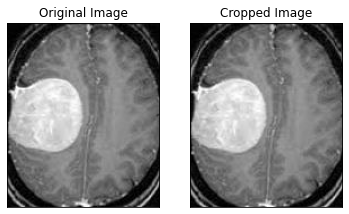

In [4]:
example_image = cv2.imread('Medical Imaging\Brain_Tumor_MRI\yes\Y1.jpg')
example_new_image = crop_image_contour(example_image, True)

# Photos were already previously cropped by me

In [5]:
# Folder Direcrories
yes_folder_dir = 'C:\\Users\\Peter\\Medical Imaging\\Brain_Tumor_MRI\\yes' 
no_folder_dir = 'C:\\Users\\Peter\\Medical Imaging\\Brain_Tumor_MRI\\no'

In [6]:
# Crop all photos in yes tumor folder
for i in os.listdir(yes_folder_dir):
    inpath = os.path.join(yes_folder_dir, i)
    image = cv2.imread(inpath)
    cropped_image = crop_image_contour(image)
    outpath = os.path.join(yes_folder_dir,i)
    save_img(outpath, cropped_image)

In [7]:
# Crop all photos in no tumor folder
for i in os.listdir(no_folder_dir):
    inpath = os.path.join(no_folder_dir, i)
    image = cv2.imread(inpath)
    cropped_image = crop_image_contour(image)
    outpath = os.path.join(no_folder_dir,i)
    save_img(outpath, cropped_image)

In [8]:
# Split into train / test / validate folders 

os.chdir("C:/Users/Peter/Medical Imaging/Brain_Tumor_MRI")
if os.path.isdir('train/yes') is False:
    os.makedirs('train/yes')
    os.makedirs('train/no')
    os.makedirs('valid/yes')
    os.makedirs('valid/no')
    os.makedirs('test/yes')
    os.makedirs('test/no')
    
    for i in random.sample(glob.glob('C:/Users/Peter/Medical Imaging/Brain_Tumor_MRI/yes/**'), 68):
        shutil.move(i, 'train/yes')
    for i in random.sample(glob.glob('C:/Users/Peter/Medical Imaging/Brain_Tumor_MRI/no/**'), 68):
        shutil.move(i, 'train/no')
        
    for i in random.sample(glob.glob('C:/Users/Peter/Medical Imaging/Brain_Tumor_MRI/yes/**'), 15):
        shutil.move(i, 'valid/yes')
    for i in random.sample(glob.glob('C:/Users/Peter/Medical Imaging/Brain_Tumor_MRI/no/**'), 15):
        shutil.move(i, 'valid/no')
        
    for i in random.sample(glob.glob('C:/Users/Peter/Medical Imaging/Brain_Tumor_MRI/yes/**'), 15):
        shutil.move(i, 'test/yes')
    for i in random.sample(glob.glob('C:/Users/Peter/Medical Imaging/Brain_Tumor_MRI/no/**'), 15):
        shutil.move(i, 'test/no')
        
os.chdir('../../')

In [9]:
train_path = 'C:/Users/Peter/Medical Imaging/Brain_Tumor_MRI/train'
valid_path = 'C:/Users/Peter/Medical Imaging/Brain_Tumor_MRI/valid'
test_path = 'C:/Users/Peter/Medical Imaging/Brain_Tumor_MRI/test'

In [10]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['no', 'yes'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['no', 'yes'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['no', 'yes'], batch_size=10, shuffle = False)

Found 136 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [11]:
assert train_batches.n == 136
assert valid_batches.n == 30
assert test_batches.n == 30
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [12]:
imgs, labels = next(train_batches)

In [13]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

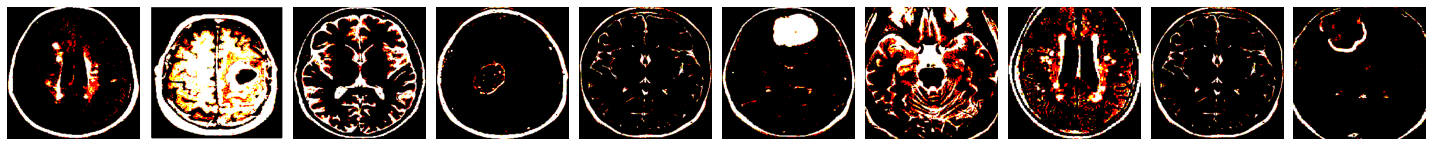

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [14]:
plotImages(imgs)
print(labels)

### Build and Train a CNN

In [15]:
model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
        MaxPool2D(pool_size=(2,2), strides=2),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        Flatten(),
        Dense(units=2, activation='softmax'),
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=20, verbose=2)

Epoch 1/20
14/14 - 2s - loss: 76.3601 - accuracy: 0.5294 - val_loss: 53.5533 - val_accuracy: 0.5000 - 2s/epoch - 123ms/step
Epoch 2/20
14/14 - 1s - loss: 16.0402 - accuracy: 0.6691 - val_loss: 23.0963 - val_accuracy: 0.6333 - 1s/epoch - 98ms/step
Epoch 3/20
14/14 - 1s - loss: 5.3447 - accuracy: 0.7574 - val_loss: 6.8395 - val_accuracy: 0.6333 - 1s/epoch - 101ms/step
Epoch 4/20
14/14 - 1s - loss: 2.3328 - accuracy: 0.8971 - val_loss: 8.8995 - val_accuracy: 0.7000 - 1s/epoch - 101ms/step
Epoch 5/20
14/14 - 1s - loss: 1.2937 - accuracy: 0.9191 - val_loss: 7.8292 - val_accuracy: 0.6667 - 1s/epoch - 99ms/step
Epoch 6/20
14/14 - 1s - loss: 0.4374 - accuracy: 0.9632 - val_loss: 5.2001 - val_accuracy: 0.6333 - 1s/epoch - 101ms/step
Epoch 7/20
14/14 - 1s - loss: 0.1905 - accuracy: 0.9559 - val_loss: 2.9199 - val_accuracy: 0.8333 - 1s/epoch - 102ms/step
Epoch 8/20
14/14 - 1s - loss: 0.1240 - accuracy: 0.9853 - val_loss: 6.3156 - val_accuracy: 0.6333 - 1s/epoch - 106ms/step
Epoch 9/20
14/14 - 1s 

### Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

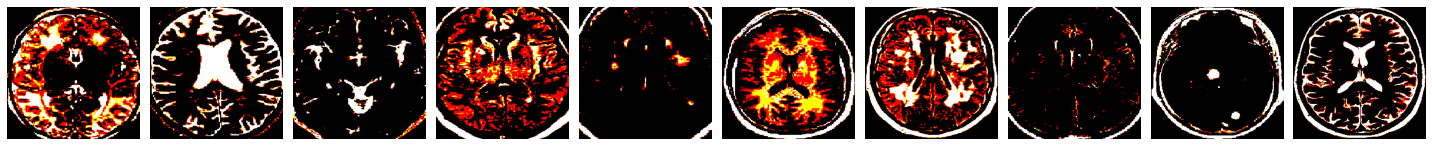

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [19]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [20]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
predictions = model.predict(x=test_batches, verbose=0)

In [22]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [23]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [24]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm= cm.astype('float') / cm.sum(axis=1)[:, np,newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
test_batches.class_indices

{'no': 0, 'yes': 1}

Confusion matrix, without normalization
[[13  2]
 [11  4]]


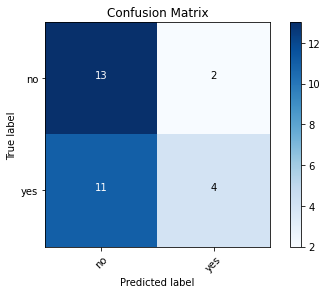

In [26]:
cm_plot_labels = ['no', 'yes']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = 'Confusion Matrix')